# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-l`
  - Task 5: Evaluating our Retriever



#### Basic Overview of Fine-tuning Embeddings

In essence, what we want to do when we fine-tune our embedding models is very simple:

```
Move the embeddings for questions relating to a document
closer together with that document
```

We can think of fine-tuning our embedding models as follows:

1) We have some pair of text items that *should* be closer together
  - `Question`, `Document` pairs
  - EX: `Who drives the bus?`, `The bus was driven by Kyle, the Bus Driver`.

2) We use these pairs as labeled data to fine-tune our embedding model.

The process of training helps the model more accurately associate our questions with the correct documents.

##### ❓ Question #1:

Describe the nuance between using Q&D pairs to train the embedding model vs. inter-document pairs/related sentences.

What caveats does this approach have? Are there any special considerations for what kind of Q's we should use?

##### ✅ Answer:
+ The Q and D pairs pattern helps train for retrieval given a query
+ inter-document pairs/related sentences help train the model for classification or general similarity use cases (exploratory; semantic).

My initial guesses about the second part of the question were:
+ Caveat: You do not want to use only one of these two patterns. Doing so limits the model's performance when responding to queries of the other pattern's type.

+ Considerations:
  + You need to ensure there is a strong correlation (or strong negative correlation) between the question and the document
  + The questions need to be concise; answerable in one retrieval; cover specific topics in the domain we are tuning for; Informative (for example include the phrase an acronym stands for to reenforce it's meaning)

The following table that ChatGPT offered is a good reference:

| Criterion                   | Description                                                                       | Goal / Example                                               | Rating Scale                          |
| --------------------------- | --------------------------------------------------------------------------------- | ------------------------------------------------------------ | ------------------------------------- |
| **1. Relevance**            | Does the question clearly align with the document’s content?                      | The doc contains a clear answer to the question              | ❌ Off-topic → ✅ Direct match          |
| **2. Specificity**          | Is the question focused on a specific detail or idea?                             | "What does GPU stand for?" vs. "What is computing?"          | ❌ Too vague → ✅ Targeted              |
| **3. Retrievability**       | Could the correct doc be selected by a retriever using only this question?        | Works with embeddings alone — no external reasoning required | ❌ Too broad → ✅ Locatable             |
| **4. Variety**              | Does the dataset include a mix of question types?                                 | Definitions, how-tos, comparisons, etc.                      | ❌ Repetitive → ✅ Diverse              |
| **5. Terminology Coverage** | Are acronyms, synonyms, and alternate phrasings used across the dataset?          | Improves robustness to real-world language                   | ❌ Homogeneous → ✅ Linguistically rich |
| **6. Domain Alignment**     | Does the question make sense in the target domain?                                | A "checkout error" question for an e-commerce product doc    | ❌ Generic → ✅ Domain-aware            |
| **7. Context Granularity**  | Is the document chunk the smallest self-contained unit that answers the question? | Avoids overly large or noisy chunks                          | ❌ Overly broad → ✅ Focused            |
| **8. Ambiguity Avoidance**  | Is the question free from double meanings or unclear references?                  | Avoids confusion during embedding training                   | ❌ Ambiguous → ✅ Clear                 |



## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

> NOTE: You do not need to do these steps if you are running this notebook locally with `uv`.

In [2]:
!pip install -qU "langchain_openai>=0.3.4" "langchain_huggingface" "langchain_core>=0.3.34" "langchain>=0.3.18" "langchain_community>=0.3.17" "langchain-text-splitters>=0.3.6" "datasets>=3.2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4

In [3]:
!pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 pymupdf beautifulsoup4 lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 19.1 MB/s eta 0:00:00


### Provide OpenAI API Key

In [4]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

Enter Your OpenAI API Key: ··········


## Task 2: Loading Data

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [5]:
!mkdir data

In [6]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31554    0 31554    0     0  33290      0 --:--:-- --:--:-- --:--:-- 33284


In [7]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70721    0 70721    0     0  72254      0 --:--:-- --:--:-- --:--:-- 72237


In [8]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader

path = "data/"
text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

Next we can load/split these documents as follows.

> NOTE: You may need to run this cell twice to get it to work.

In [10]:
training_documents = text_splitter.split_documents(text_loader.load())

In [11]:
len(training_documents)

102

Next, we're going to associate each of our chunks with a unique identifier.

In [12]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [13]:
training_split_documents = training_documents[:len(training_documents) - 24]
val_split_documents = training_documents[len(training_documents) - 24:102-12]
test_split_documents = training_documents[102-12:]

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4.1-mini`

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [14]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [15]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [16]:
question_generation_chain = qa_prompt_template | qa_chat_model

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

##### 🏗️ Activity #1:

We have:

- Lists of `Documents` with the `metadata` field `id`.

We need:

- An object with key `id`, which have values `str` questions.
- An object with key `question_id`, which have values `List(str)` which will be a list of associated `context_id`.

An Example:

question_object:
```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': 'What types of accessible formats are available for persons with disabilities?',
'df58ee4f-714c-419e-8324-94e5870574e2': 'How do accessible formats benefit persons with disabilities?',
'505fce8b-0e56-48de-a251-61027e396918': 'What are some of the risks associated with the increasing capabilities of AI systems that generate synthetic content?',
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': 'Why is it important for providers of AI systems to embed technical solutions for marking and detecting synthetic content?'
}
 ```

 context_object:
 ```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'df58ee4f-714c-419e-8324-94e5870574e2': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'505fce8b-0e56-48de-a251-61027e396918': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
}
 ```

 As you can see, a piece of context can be associated with more than 1 question.

 The task is to write the Python function(s) to accomplish this task.

 Your function signature is provided below, along with the desired return values.

 > NOTE: You can make any modifications that you desire - assuming that you have the correct input and outputs.

In [17]:
import tqdm
import asyncio

"""
Sample Usage of TQDM:

for i in tqdm.tqdm(range(10)):
  time.sleep(1)
"""

async def process_document(document, n_questions):
    questions_generated = await question_generation_chain.ainvoke({"context": document.page_content, "n_questions": n_questions})

    doc_questions = {}
    doc_relevant_docs = {}

    for question in questions_generated.content.split("\n"):
        question_id = str(uuid.uuid4())
        doc_questions[question_id] = "".join(question.split(".")[1:]).strip()
        doc_relevant_docs[question_id] = [document.metadata["id"]]

    return doc_questions, doc_relevant_docs

async def create_questions(documents, n_questions):
    tasks = [process_document(doc, n_questions) for doc in documents]

    questions = {}
    relevant_docs = {}

    for task in tqdm.tqdm(asyncio.as_completed(tasks), total=len(documents), desc="Processing documents"):
        doc_questions, doc_relevant_docs = await task
        questions.update(doc_questions)
        relevant_docs.update(doc_relevant_docs)

    return questions, relevant_docs

### REMOVE `await` IF NOT USING ASYNC (HINT: Use `async`)

In [18]:
training_questions, training_relevant_contexts = await create_questions(training_split_documents, 2)

Processing documents: 100%|██████████| 78/78 [00:06<00:00, 12.49it/s]


We'll use the function to generate training, validation, and test data.

In [19]:
val_questions, val_relevant_contexts = await create_questions(val_split_documents, 2)

Processing documents: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


In [20]:
test_questions, test_relevant_contexts = await create_questions(test_split_documents, 2)

Processing documents: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

In [21]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [22]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [23]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-l`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-l`](https://huggingface.co/Snowflake/snowflake-arctic-embed-l) as a base embeddings model.

It is a well performing embeddings model by itself, but there's a lot of very specific domain terms and vocabulary in our courpus - so lets fine-tune it and see what that can do for us!

>> NOTE: Skip installing dependencies if you are running this notebook locally.

In [24]:
!pip install -qU sentence_transformers pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 60.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.


In [25]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [26]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [27]:
BATCH_SIZE = 10

Let's move our dataset into the expected format for training.

In [28]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [29]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [30]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

##### 🏗️ Activity #2:

Both of these losses sound "cool", but what are they - exactly - under the hood?

Why are these losses specifically doing? Please write a short summary of each loss.

> NOTE: This is a course focused on AI Engineering and the application of AI - looking for a hint? Try pasting the code (linked above) into ChatGPT/Claude to write the summary!

##### ✅ Answer:

_**What are they under the hood?**_
+ **MultipleNegativesRankingLoss:**
  + Purpose: Learn embeddings such that a query is closer to its correct document than to all other documents in the batch.
  + How it works:
    + Given a batch of (query, positive_doc) pairs, the other documents in the batch are treated as negatives for each query.
    + It uses a softmax over cosine similarities, encouraging the query to be closer to its true doc than to any other.
    + It’s efficient because it reuses other positives as negatives, removing the need to mine negative examples manually.
+ **MatryoshkaLoss:**
  + Purpose: Learn embeddings that work well at multiple levels of dimensionality — useful for flexibility and memory-constrained retrieval.
  + How it works:
    + Wraps another loss (like MNRL) and computes that loss at several reduced dimensions.
    + This trains the model to retain useful information even when embeddings are truncated (e.g., from 768 → 128 dimensions).
    + Named after Matryoshka dolls because smaller embeddings "fit inside" larger ones.

_**Summary of what each one does:**_
+ **MultipleNegativesRankingLoss:** Pulls the query and correct document close together — and pushes all other documents in the batch further away.
  + Simple, powerful loss for contrastive learning.
  + Optimized for Q&A or retrieval-style fine-tuning.
  + Uses the batch itself as negative examples (saves time & compute).
+ **MatryoshkaLoss:** Train one model that works well across multiple embedding sizes — so you can trade off performance vs. memory later without retraining.
  + Trains embeddings to be robust even when you cut off dimensions.
  + Useful when deploying on edge devices or needing fast indexing.

In the preceding code cell the two loss algorithms are nested. So at each embedding dimension, the MultipleNegativesRankingLoss runs first, bringing the query and correct document closer while pushing away the others; then the MatryoshkaLoss runs, reducing the embedding dimensions. Then the loop repeats. In this way, the model is trained to produce high-quality embeddings even at reduced dimensions.

Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [31]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [32]:
EPOCHS = 10

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [33]:
import wandb
import uuid
import statistics

# Start a new run
wandb.init(
    project="AIE6 - Session 09",
    name=f"run-{str(uuid.uuid4())[:8]}",
    tags=["question-generation", "embedding", "fine-tuning"],
    notes="Synthetic question generation from product documents"
)

# Example simulated stats after generating questions
n_documents = len(training_documents)
question_counts = [7, 6, 8, 7, 9]  # Replace with actual per-doc stats
total_questions = sum(question_counts)
avg_questions = statistics.mean(question_counts)

# Log basic run-level metrics
wandb.log({
    "n_documents": n_documents,
    "total_questions": total_questions,
    "avg_questions_per_doc": avg_questions
})

# Optional: log histogram of question distribution
wandb.log({
    "questions_distribution": wandb.Histogram(question_counts)
})

# Optional: log list of sample questions (from earlier collection)
# wandb.log({"sample_questions": wandb.Table(data=sample_q_list, columns=["question"])})

# Finish run (optional in notebooks)
wandb.finish()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tamark22 (tamark22-tamark-designs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


avg_questions_per_doc,▁
n_documents,▁
total_questions,▁
avg_questions_per_doc,7.4
n_documents,102
total_questions,37


> NOTE: You may not see direct improvement during the training cycles - this is absolutely expected. We will verify performance later in the notebook.

In [34]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task cancelling name='Task-1002' coro=<Event.wait() running at /usr/lib/python3.11/asyncio/locks.py:213> wait_for=<Future cancelled>>


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
16,No log,No log,0.958333,1.000000,1.000000,1.000000,0.958333,0.333333,0.200000,0.100000,0.958333,1.000000,1.000000,1.000000,0.979167,0.972222,0.972222
32,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
48,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
50,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
64,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.948411,0.930556,0.930556
80,No log,No log,0.875000,1.000000,1.000000,1.000000,0.875000,0.333333,0.200000,0.100000,0.875000,1.000000,1.000000,1.000000,0.948411,0.930556,0.930556
96,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.963789,0.951389,0.951389
100,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
112,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333
128,No log,No log,0.916667,1.000000,1.000000,1.000000,0.916667,0.333333,0.200000,0.100000,0.916667,1.000000,1.000000,1.000000,0.969244,0.958333,0.958333


In [38]:
from huggingface_hub import notebook_login

notebook_login()

In [36]:
hf_username = "mwalker22"

In [39]:
import uuid

model.push_to_hub(f"{hf_username}/AIE6-S09-{uuid.uuid4()}")

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

'https://huggingface.co/mwalker22/AIE6-S09-87aedf81-ffbc-41ed-b4b6-8473344cae65/commit/6c94d0606db73db3c5f1ed9dfafbb0c92b7d11c0'

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [40]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [41]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [42]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 24/24 [00:15<00:00,  1.54it/s]


In [43]:
te3_results_df = pd.DataFrame(te3_results)

In [44]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

np.float64(1.0)

### `Snowflake/snowflake-arctic-embed-l` (base)

In [45]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 24/24 [00:00<00:00, 50.05it/s]


In [46]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [47]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

np.float64(0.7916666666666666)

### `Snowflake/snowflake-arctic-embed-l` (fine-tuned)

In [48]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="finetuned_arctic_ft")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic_ft and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 24/24 [00:00<00:00, 49.55it/s]


In [49]:
finetune_results_df = pd.DataFrame(finetune_results)

In [50]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

np.float64(1.0)

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [51]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [52]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [53]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [54]:
rag_llm =  ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [55]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [56]:
base_rag_chain.invoke({"question" : "What is an agent?"})["response"]

'Based on the provided context, an "agent" in the context of AI refers to systems that can act on your behalf, such as travel agents or digital assistants. However, the term is highly vague and lacks a clear, universally accepted definition. Different people interpret "agents" differently—some see them as systems that go and act independently, while others think of them as LLMs with access to tools that can be used iteratively to solve problems. Despite the excitement around AI agents, their practical utility remains uncertain, partly due to issues like gullibility and the difficulty in distinguishing truth from fiction. Overall, "agent" is a loosely defined term that still lacks a precise, agreed-upon meaning in the AI community.'

In [57]:
base_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Several organizations have produced models that are better than GPT-3, including Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, and Baidu.'

In [58]:
base_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'The provided context does not specify a particular time of year that is considered the "laziest" for AI.'

In [59]:
base_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The provided context does not specify who Simon is or what the largest model he has run on his phone is. Therefore, I do not know the answer.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [60]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [61]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [62]:
finetune_rag_chain.invoke({"question" : "What is an Agent?"})["response"]

'Based on the provided context, an "agent" in the context of AI refers to systems that are envisioned to act on behalf of users, such as personal assistants or autonomous entities. However, the term is highly vague and lacks a clear, universally accepted definition. The discussions highlight that many claims about AI agents are often ambiguous, and despite ongoing development and prototypes, fully functional and reliable AI agents are still "coming soon." Additionally, skepticism exists regarding their utility, primarily because current AI systems, like LLMs, can believe false information and struggle to distinguish truth from fiction, which limits their effectiveness as autonomous agents.'

In [63]:
finetune_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'According to the provided context, multiple organizations have produced models that are better than GPT-3. Specifically, the text mentions that "we’ve now seen better-than-GPT-3 class models produced by Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, Baidu and a bunch of other organizations."'

In [64]:
finetune_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'The provided context suggests that ChatGPT may get lazy in December, possibly because its hidden system prompt includes the current date and its training data shows that people provide less useful answers approaching the holidays. Therefore, the laziest time of the year for AI, according to the context, is December.'

In [65]:
finetune_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The largest model that Simon has run on his phone is Mistral 7B.'

#### ❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?

##### ✅ Answer:

The fined tuned model answered the questions better:
1. _What is an Agent:_ The fine-tuned model's response was more conversational and easier to understand.
2. _Who has produced better models than GPT-3?_ This one was a wash between the two models.
3. _What is the laziest time of the year for AI?_ Again, more conversational. It also included additional, valuable information.
4. _What is the largest model that Simon has run on his phone?_ The fine-tuned model's response was factually correct. This inormation was not found by the original model.

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [66]:
!pip install ragas datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.5 MB/s eta 0:00:00


In [67]:
wandb.finish()

eval/cosine_accuracy@1,▁▁▁
eval/cosine_accuracy@10,▁▁▁
eval/cosine_accuracy@3,▁▁▁
eval/cosine_accuracy@5,▁▁▁
eval/cosine_map@100,▁▁▁
eval/cosine_mrr@10,▁▁▁
eval/cosine_ndcg@10,▁▁▁
eval/cosine_precision@1,▁▁▁
eval/cosine_precision@10,▁▁▁
eval/cosine_precision@3,▁▁▁
eval/cosine_precision@5,▁▁▁


In [68]:
!pip show ragas


Name: ragas
Version: 0.2.15
Summary: 
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: appdirs, datasets, diskcache, langchain, langchain-community, langchain-core, langchain_openai, nest-asyncio, numpy, openai, pydantic, tiktoken
Required-by: 


In [78]:
### YOUR CODE HERE
"""
***** This first section prepares the dataset that ragas will need to perform its evaluation. *****
"""
import wandb

# Step 1: Init wandb run
wandb.init(
    project="AIE6 - Session 09",
    name=f"ragas-eval-run-{str(uuid.uuid4())[:8]}",
    tags=["fine-tuned", "embedding", "RAGAS"],
    notes="Generating responses and context using finetuned RAG chain for RAGAS evaluation"
)

# Step 2: Build records
ragas_records = []

for idx, row in tqdm.tqdm(finetune_results_df.iterrows(), total=len(finetune_results_df), desc="Running RAG chain"):
    question = row["question"]
    expected_id = row["expected_id"]
    ground_truth = training_corpus.get(expected_id, "")
    try:
        result = finetune_rag_chain.invoke({"question": question})
        answer = result.get("response", "")
        contexts = result.get("context", [])

        # Extract raw strings if context is a list of Documents
        if contexts and hasattr(contexts[0], "page_content"):
            contexts = [c.page_content for c in contexts]

        ragas_records.append({
            "question": question,
            "answer": answer,
            "ground_truth": ground_truth,
            "contexts": contexts
        })

        # Optional: log to wandb (e.g., length of context, etc.)
        wandb.log({
            "question_length": len(question),
            "answer_length": len(answer),
            "context_count": len(contexts)
        })

    except Exception as e:
        print(f"[{idx}] Failed for question: {question[:40]}... — {e}")
        wandb.log({"error_count": 1})

# Step 3: Convert to DataFrame and Evaluation Dataset
ragas_df = pd.DataFrame(ragas_records)

from datasets import Dataset
evaluation_dataset = Dataset.from_pandas(ragas_df)

"""
***** This final section will run the RAGAS evaluation: *****
"""
from ragas import evaluate, RunConfig
from ragas.metrics import (
    LLMContextRecall,
    Faithfulness,
    FactualCorrectness,
    ResponseRelevancy,
    ContextEntityRecall,
    NoiseSensitivity
)
from ragas.llms import LangchainLLMWrapper
from langchain.chat_models import ChatOpenAI

# Step 1: Wrap the evaluator LLM
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))

# Step 2: Run RAGAS evaluation
custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[
        LLMContextRecall(),
        Faithfulness(),
        FactualCorrectness(),
        ResponseRelevancy(),
        ContextEntityRecall(),
        NoiseSensitivity()
    ],
    llm=evaluator_llm,
    run_config=custom_run_config
)

# Step 3: Log final RAGAS scores to wandb
for metric, value in result._scores_dict.items():
    wandb.log({f"RAGAS_{metric}": value})

# Optionally end the run if you're done logging
wandb.finish()

# Step 4: Show results
result



ERROR:asyncio:Task was destroyed but it is pending!
task: <Task cancelling name='Task-8964' coro=<Event.wait() running at /usr/lib/python3.11/asyncio/locks.py:213> wait_for=<Future cancelled>>


Running RAG chain: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[5]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[11]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[17]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[23]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[29]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[35]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[41]: ValueError(reference is missing in the test sample. Please add reference to the test sa

answer_length,▄▃▁▁▂▃▃▁▃▁▄▂▃▄▁▁▃▇▇▇█▆▂▂
context_count,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
question_length,▃▅▂▂▂▂▄▄▅▄▆▁▂▅▄▄▄▃█▆▆▅▄▄
answer_length,127
context_count,6
question_length,83


ERROR:asyncio:Task was destroyed but it is pending!
task: <Task cancelling name='Task-11088' coro=<Event.wait() running at /usr/lib/python3.11/asyncio/locks.py:213> wait_for=<Future cancelled>>


{'context_recall': nan, 'faithfulness': 0.8225, 'factual_correctness(mode=f1)': 0.0946, 'answer_relevancy': 0.7626, 'context_entity_recall': 0.0000, 'noise_sensitivity(mode=relevant)': nan}

## Comparison Runs
I have added the two code cells below which will:
1. Run the same RAGA evaluation against the base model
2. Logs the results of both runs to WandB for comparison

In [79]:
# === RAGAS Evaluation: Baseline Embedding Model ===

from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from sentence_transformers import SentenceTransformer
from datasets import Dataset as HFDataset
from langchain.schema import Document

# Step 1: Build the base embedding model + retriever
base_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
base_vectorstore = FAISS.from_documents(training_documents, base_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

# Step 2: Build base RAG chain
base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

# Step 3: Run inference and prepare RAGAS records
base_ragas_records = []
for idx, row in tqdm.tqdm(finetune_results_df.iterrows(), total=len(finetune_results_df), desc="Running base RAG chain"):
    question = row.question
    expected_id = row.expected_id
    ground_truth = training_corpus.get(expected_id, "")

    try:
        rag_response = base_rag_chain.invoke({"question": question})
        answer = rag_response.get("response", "")
        contexts = rag_response.get("context", [])

        # Convert Document objects (or other structures) to plain strings
        if isinstance(contexts, list):
            contexts = [c.page_content if hasattr(c, "page_content") else str(c) for c in contexts]
        else:
            contexts = [str(contexts)]

        base_ragas_records.append({
            "question": question,
            "answer": answer,
            "contexts": contexts,
            "ground_truth": ground_truth
        })
    except Exception as e:
        print(f"⚠️ Skipped due to error: {e}")

# Step 4: Create HF Dataset
base_ragas_df = pd.DataFrame(base_ragas_records)
base_evaluation_dataset = HFDataset.from_pandas(base_ragas_df)

# Step 5: Run evaluation
base_result = evaluate(
    dataset=base_evaluation_dataset,
    metrics=[
        LLMContextRecall(),
        Faithfulness(),
        FactualCorrectness(),
        ResponseRelevancy(),
        ContextEntityRecall(),
        NoiseSensitivity()
    ],
    llm=evaluator_llm,
    run_config=custom_run_config
)

# Step 6: Print metric comparison
wandb.init(
    project="AIE6 - Session 09",
    name=f"ragas-eval-run-{str(uuid.uuid4())[:8]}",
    tags=["base-not-tuned", "embedding", "RAGAS"],
    notes="Generating responses and context using base model RAG chain for RAGAS evaluation"
)

for metric, value in base_result._scores_dict.items():
    wandb.log({f"RAGAS_{metric}": value})

base_result


Running base RAG chain: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[5]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[11]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[17]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[23]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[29]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[35]: ValueError(reference is missing in the test sample. Please add reference to the test sample.)
ERROR:ragas.executor:Exception raised in Job[41]: ValueError(reference is missing in the test sample. Please add reference to the test sa

{'context_recall': nan, 'faithfulness': 0.7375, 'factual_correctness(mode=f1)': 0.1029, 'answer_relevancy': 0.5978, 'context_entity_recall': 0.0000, 'noise_sensitivity(mode=relevant)': nan}

## Comparison Results:
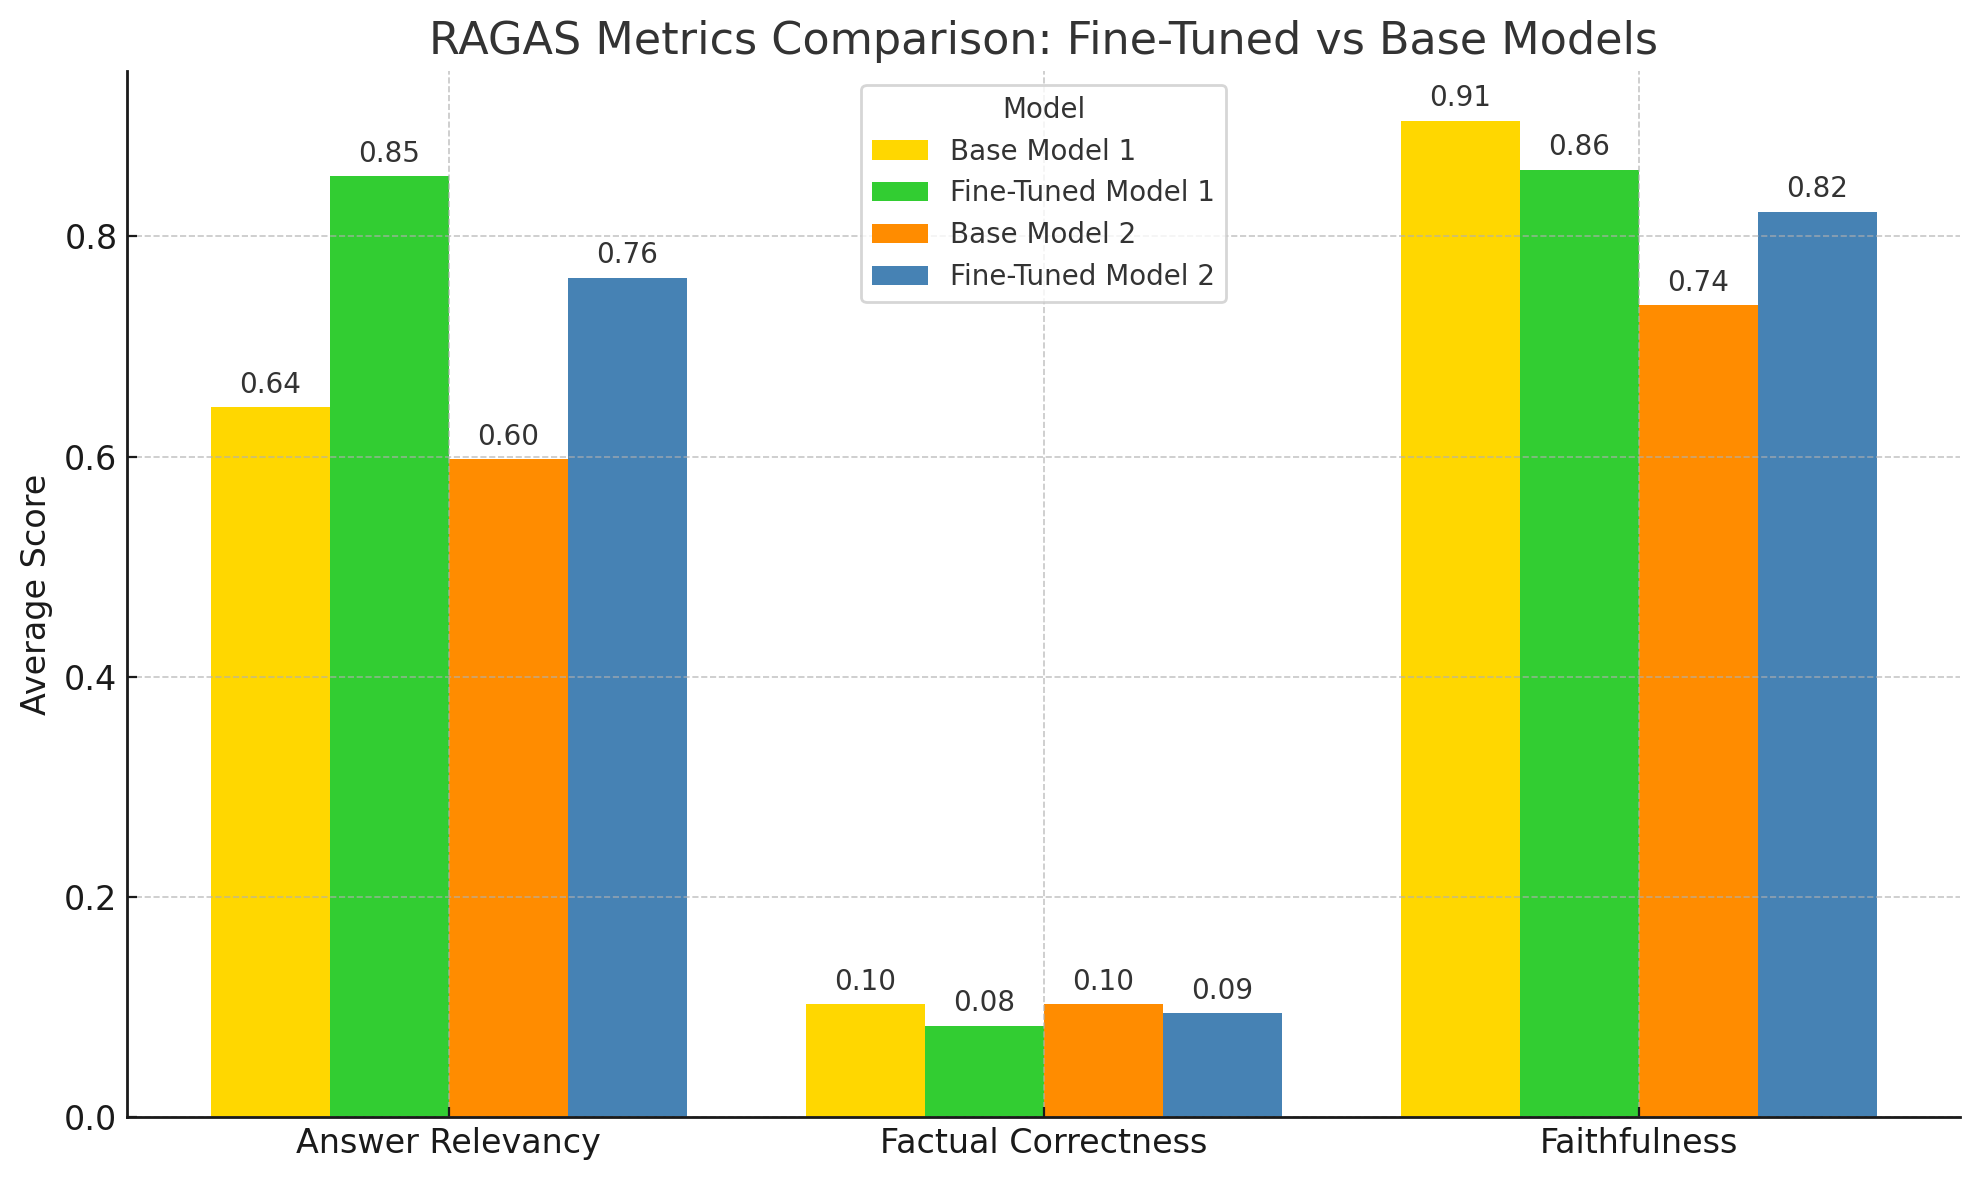